In [1]:
import arepo_run as arun
import matplotlib.pylab as plt
import numpy as np
import gadget
import yt
import cmasher

#Some constants
gamma    = 5./3
unit_m   = 1.989e43
unit_v   = 1.e5
unit_l   = 3.09567758e21
unit_t   = unit_l/unit_v
unit_rho = unit_m/unit_l**3




In [2]:
#Snapshot
num  = 1
#Read
o  = arun.Run(snappath='/cosma8/data/dp317/dc-naza3/gasCloudNfw/output2', snapbase="snap_")
s  = o.loadSnap(snapnum=num)

In [3]:
s.data.keys()

dict_keys(['flga', 'wind', 'pos', 'rho', 'grar', 'edis', 'u', 'mach', 'mass', 'id', 'pres', 'vel', 'vol', 'vort', 'type'])

In [ ]:
def radial_profile(s, value, radial_range=None, nbins=50):
    """
    Bin 3D data into radial bins assuming spherical symmetry.

    Parameters:
    -----------
    s : object
        Snapshot object containing data
    positions : array
        Particle positions (N, 3)
    value : str
        Key of quantity to bin (e.g., 'density', 'temperature')
    radial_range : tuple, optional
        (r_min, r_max) in code units. If None, uses full range
    nbins : int
        Number of radial bins

    Returns:
    --------
    r_bin : array
        Radial bin centers
    value_bin : array
        Binned quantity (mean values)
    """
    positions = s.pos
    #calcualting temperature
    if value == 'temp':
        kB       = 1.381e-16
        mP       = 1.66e-24
        xH       = 0.76
        meanMolecularWeight = 0.6*mP #4* mP / (1 + 3*xH + 4*xH * s.data['ne'])#/(s.data['rho'] * unit_rho * xH/mP))
        s.data['temp']      = (gamma - 1) * meanMolecularWeight / kB * s.data['u'] * unit_v**2

    #calculating speed
    if value == 'speed':
        s.data['speed']     = np.linalg.norm(s.data['vel'], axis=1)

    #calculationg vorticity magnitude
    if value == 'vortmag':
        s.data['vortmag']     = np.linalg.norm(s.data['vortmag'], axis=1)
    
    #calculating density gradient to find shocks (grad rho/rho<<1 for sound waves)
    if value == 'grar_rho':
        s.data['grar_rho']=np.linalg.norm(s.data['grar'],axis=1)/s.data['rho']

    if value == 'energdens':
        s.data['energdens'] = s.data['u']*s.data['rho']
        
    if value == 'bflds':
        s.data['bflds'] = np.linalg.norm(s.data['bfld'], axis=1)
    # Center of the box
    center = np.array([500, 500, 500])
    # Calculate radial distance from box center
    r = np.linalg.norm(positions - center, axis=1)

    s.data['vrad'] = np.sum((positions - center) * s.data['vel'], axis=1) / r    
    
    # Set radial range
    if radial_range is None:
        r_min, r_max = r.min(), r.max()
    else:
        r_min, r_max = radial_range
    
    # Create radial bins
    r_bins = np.linspace(r_min, r_max, nbins + 1)
    r_bin = (r_bins[:-1] + r_bins[1:]) / 2
    
    # Bin the quantity
    value_bin, _ = np.histogram(r, bins=r_bins, weights=s.data[value])
    counts, _ = np.histogram(r, bins=r_bins)
    value_bin /= counts
    
    return r_bin, value_bin

In [ ]:
def plot_normalized_comparison(s, val1='u', val2='rho', 
                                y1_label='Energy Density', y2_label='Density',
                                xlabel='Radius [kpc]',
                                ylabel='Normalized Value',
                                title='Radial Profile Comparison',
                                figsize=(10, 6),
                                colors=('#1f77b4', '#ff7f0e'),
                                show_ranges=True,radial_range=(0, 100),
                                nbins=1000,logplot=False, norm=True, newfig=True):
    """
    Create a publication-quality comparison plot of two normalized quantities.
    
    Parameters:
    -----------
    val1 : str
        First quantity to plot
    val2 : str
        Second quantity to plot
    y1_label : str
        Label for first quantity
    y2_label : str
        Label for second quantity
    xlabel : str, optional
        X-axis label (default: 'Radius [kpc]')
    ylabel : str, optional
        Y-axis label (default: 'Normalized Value')
    title : str, optional
        Plot title (default: 'Radial Profile Comparison')
    figsize : tuple, optional
        Figure size (default: (10, 6))
    colors : tuple, optional
        Colors for the two lines (default: ('#1f77b4', '#ff7f0e'))
    show_ranges : bool, optional
        Print original value ranges (default: True)
    norm : bool, optional
        Whether to normalize the values (default: True)
    
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
    """
    # Reset matplotlib to defaults first to clear any previous settings
    plt.rcdefaults()
    
    # Set LaTeX-style rcParams for publication-quality plots
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['DejaVu Serif', 'Computer Modern Roman'],
        'text.usetex': False,
        'mathtext.fontset': 'cm',
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'legend.fontsize': 11,
        'xtick.labelsize': 11,
        'ytick.labelsize': 11,
        'figure.figsize': figsize,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linestyle': '--',
        'lines.linewidth': 2.5,
        'axes.linewidth': 1.2,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.size': 5,
        'ytick.major.size': 5,
    })  

    r_bin, y1_values= radial_profile(s, val1, radial_range=radial_range, nbins=nbins)
    r_bin, y2_values = radial_profile(s, val2, radial_range=radial_range, nbins=nbins)
    
    # Normalize both quantities (subtract min, divide by range)
    if norm:
        y1_norm = (y1_values - np.nanmin(y1_values)) / (np.nanmax(y1_values) - np.nanmin(y1_values))
        y2_norm = (y2_values - np.nanmin(y2_values)) / (np.nanmax(y2_values) - np.nanmin(y2_values))
    else:
        y1_norm = y1_values
        y2_norm = y2_values
    
    # Create the plot
    if newfig:
        fig, ax = plt.subplots(figsize=figsize)
    if logplot:
        plt.semilogy(r_bin, y1_norm, label=f'{y1_label} (normalized)', 
                color=colors[0], linewidth=2.5, alpha=0.9)
        plt.semilogy(r_bin, y2_norm, label=f'{y2_label} (normalized)', 
                color=colors[1], linewidth=2.5, alpha=0.9)

    else:
        plt.plot(r_bin, y1_norm, label=f'{y1_label} (normalized)', 
                color=colors[0], linewidth=2.5, alpha=0.9)
        plt.plot(r_bin, y2_norm, label=f'{y2_label} (normalized)', 
                color=colors[1], linewidth=2.5, alpha=0.9)
    
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16, pad=15)
    plt.legend(loc='best', frameon=True, shadow=True, fancybox=True)
    plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    
    # Set the spine width
    for spine in plt.gca().spines.values():
        spine.set_linewidth(1.2)
    
    plt.tight_layout()
    
    # Print normalization ranges for reference
    if show_ranges:
        print(f"{y1_label} - Original range: [{np.nanmin(y1_values):.3e}, {np.nanmax(y1_values):.3e}]")
        print(f"{y2_label} - Original range: [{np.nanmin(y2_values):.3e}, {np.nanmax(y2_values):.3e}]")
    
    return r_bin, y1_values, y2_values

In [ ]:
#Snapshot
#Read
o  = arun.Run(snappath='/cosma8/data/dp317/dc-naza3/gasCloudNfw/output2', snapbase="snap_")
s1  = o.loadSnap(snapnum=5)
s2 = o.loadSnap(snapnum=2)
# Example: Compare Mach Number and CR Energy Density
r_bin, temp, mach= plot_normalized_comparison(
                                            s=s1,
                                            val1='temp',
                                            val2='mach',
                                            y1_label='Temperature',
                                            y2_label='Mach number',
                                            xlabel='Radius [kpc]',
                                            title='Comparison',
                                            logplot=False,
                                            radial_range=(10, 50),
                                            nbins=1000,
                                            norm=True,
                                            colors=('#d62728', '#2ca02c')  # Red and green
                                        )
r_bin, rho, vrad= plot_normalized_comparison(
                                            s=s1,
                                            val1='rho',
                                            val2='vrad',
                                            y1_label='Density',
                                            y2_label='Radial Velocity',
                                            xlabel='Radius [kpc]',
                                            title='Comparison',
                                            logplot=False,
                                            radial_range=(10, 50),
                                            nbins=1000,
                                            norm=True,
                                            newfig=False,
                                            colors=("#9f1bb0", "#17c1db")  # Red and green
                                        )

plt.show()

NameError: name 'i' is not defined

In [42]:
def shock_region_mask(chosen_values, preshock_offset=10, postshock_offset=10, reference_profile=None):
    """
    Return mean_postshock / mean_preshock for a chosen profile around the max of a reference profile.
    """
    if reference_profile is None:
        reference_profile = mach

    if len(chosen_values) != len(reference_profile):
        raise ValueError("chosen_values and reference_profile must have the same length.")

    max_idx = int(np.nanargmax(reference_profile))
    start = max(0, max_idx - preshock_offset)
    end = min(len(reference_profile), max_idx + postshock_offset + 1)

    preshock_mask = np.zeros_like(reference_profile, dtype=bool)
    postshock_mask = np.zeros_like(reference_profile, dtype=bool)
    postshock_mask[start:max_idx] = True
    preshock_mask[max_idx:end] = True
    
    # ratio = np.nan if (np.isnan(mean_preshock) or mean_preshock == 0) else mean_postshock / mean_preshock
    return max_idx, preshock_mask, postshock_mask

def get_mean(chosen_values, mask):
    """
    Return mean of chosen values within the given mask.
    """
    values = chosen_values[mask]

    def safe_nanmean(values):
        valid = np.isfinite(values)
        return np.mean(values[valid]) if np.any(valid) else np.nan

    mean_value = safe_nanmean(values)
    return mean_value

preshock_offset = 100
postshock_offset = 100
max_idx, preshock_mask, postshock_mask = shock_region_mask(rho, preshock_offset=preshock_offset, postshock_offset=postshock_offset)
preshock_mask = preshock_mask & (mach==0)
preshock_mask = preshock_mask & (mach==0)
rho_pre = get_mean(rho, preshock_mask)
rho_post = get_mean(rho, postshock_mask)
rho_post/rho_pre

4.232021

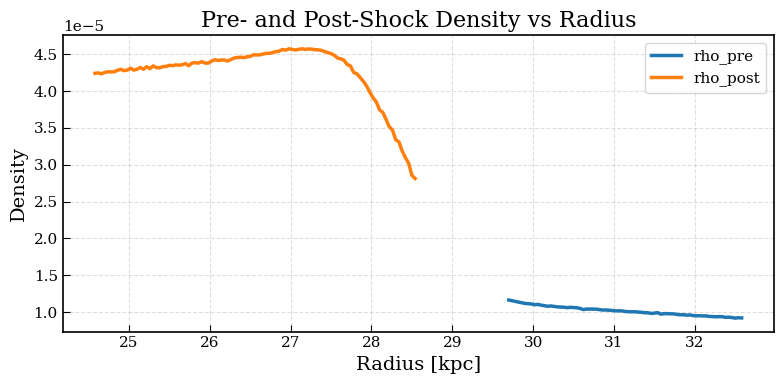

In [45]:
plt.figure(figsize=(8, 4))
plt.plot(r_bin[preshock_mask], rho[preshock_mask], label='rho_pre', color='tab:blue')
plt.plot(r_bin[postshock_mask], rho[postshock_mask], label='rho_post', color='tab:orange')
plt.xlabel('Radius [kpc]')
plt.ylabel('Density')
plt.title('Pre- and Post-Shock Density vs Radius')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()

In [36]:
v_pre = get_mean(vrad, preshock_mask)
v_post = get_mean(vrad, postshock_mask)
(-(v_pre-vrad[max_idx])/(v_post-vrad[max_idx]))
# v_pre/v_post

1.2194763321028004

In [44]:
max_mach = mach[max_idx]
(gamma+1)*max_mach**2/((gamma-1)*max_mach**2+2)

3.4123455775990195

In [15]:
max_mach

4.173747